In [8]:
data_coords = {
    0: (20, 20),
    1: (20, 40),
    2: (20, 160),
    3: (40, 120),
    4: (60, 20),
    5: (60, 80),
    6: (60, 200),
    7: (80, 180),
    8: (100, 40),
    9: (100, 120),
    10: (100, 160),
    11: (120, 80),
    12: (140, 140),
    13: (140, 180),
    14: (160, 20),
    15: (180, 60),
    16: (180, 100),
    17: (180, 200),
    18: (200, 40),
    19: (200, 160)}

data_map = {"Brighton" : {"Brighton": 0, "Bristol": 172, "Cambridge": 145, "Glasgow": 607, "Liverpool": 329,
                          "London": 72, "Manchester": 312, "Oxford": 120},
             "Bristol" : {"Brighton": 172, "Bristol": 0, "Cambridge": 192, "Glasgow": 494, "Liverpool": 209,
                          "London": 158, "Manchester": 216, "Oxford": 92},
             "Cambridge" : {"Brighton": 145, "Bristol": 192, "Cambridge": 0, "Glasgow": 490, "Liverpool": 237,
                          "London": 75, "Manchester": 205, "Oxford": 100},
             "Glasgow" : {"Brighton": 607, "Bristol": 494, "Cambridge": 490, "Glasgow": 0, "Liverpool": 286,
                          "London": 545, "Manchester": 296, "Oxford": 489},
             "Liverpool" : {"Brighton": 329, "Bristol": 209, "Cambridge": 237, "Glasgow": 286, "Liverpool": 0,
                          "London": 421, "Manchester": 49, "Oxford": 408},
             "London" : {"Brighton": 72, "Bristol": 158, "Cambridge": 75, "Glasgow": 545, "Liverpool": 421,
                          "London": 0, "Manchester": 249, "Oxford": 75},
             "Manchester" : {"Brighton": 312, "Bristol": 216, "Cambridge": 205, "Glasgow": 296, "Liverpool": 49,
                          "London": 249, "Manchester": 0, "Oxford": 194},
             "Oxford" : {"Brighton": 120, "Bristol": 92, "Cambridge": 100, "Glasgow": 489, "Liverpool": 208,
                          "London": 75, "Manchester": 194, "Oxford": 0}
            }

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random as rand

class GeneticAlgorithm:
    def __init__(self, data, dtype):
        self.data = data
        self.map_dtype = dtype

    """ generate initial population """
    def init_population(self, n):
        individuals = []

        for i in range(n):
            individuals.append(self.gen_individual())

        return individuals

    """ generate an individual """
    def gen_individual(self):
        nodes = list(self.data.keys())
        rand.shuffle(nodes)
        return nodes

    """ evaluate an individual by returning its fitness score (1 / path cost)"""
    def evaluate(self, individual):
        cost = 0

        # calculate and sum path cost to travel from node to node
        for i in range(0, len(individual)-1):
            n1 = individual[i]
            n2 = individual[i+1]
            cost += self.dist(n1, n2)

        # add cost for return
        start = individual[0]
        end = individual[len(individual)-1]
        cost += self.dist(end, start)

        return 1.0 / cost

    """ select top n individuals sorted by their fitness score"""
    def select_top(self, individuals, n):
        scores = [self.evaluate(i) for i in individuals]
        results = np.array(list(zip(individuals, scores)))
        return results[results[:,1].argsort()[::-1]][:n]

    """ select k random individuals and return the one with the highest fitness score """
    def tournament_selection(self, individuals, k):
        selection = rand.choices(individuals, k=k)
        top = self.select_top(selection, 1)
        return top[0][0]

    """ ordered crossover """
    def crossover(self, n1, n2):

        best, other = n1, n2

        if self.evaluate(n1) < self.evaluate(n2):
            best, other = other, best

        # indices for a random subset from the best individual
        start = rand.randint(0, len(best)-1)
        end = rand.randint(0, len(best)-1)

        if(start > end): #swap indices if needed
            start, end = end, start

        if(start == end): #single element
            subset = [best[start]]
            end = end+1
        else: #otherwise return subset
            subset = best[start:end]

        # remove those already within the subset
        pruned_other = [x for x in other if x not in subset]

        new = []

        # perform crossover
        for i in range(0, start):
            new.append(pruned_other.pop(0))

        new.extend(subset)

        for i in range(end, len(best)):
            new.append(pruned_other.pop(0))

        return new

    """ swap mutation """
    def mutate(self, individual):
        gene1 = rand.randint(0, len(individual)-1)
        gene2 = rand.randint(0, len(individual)-1)

        while True:
            if gene1 == gene2:
                gene2 = rand.randint(0, len(individual)-1)
            else:
                break

        new = individual.copy()

        new[gene1], new[gene2] = new[gene2], new[gene1]

        return new

    def evolve(self, _pop, N):
        new_pop = []
        k = 20
        num_elites = 1

        # add previous best to new population to guarantee the fitness cannot get worse
        best = self.select_top(_pop, num_elites)
        for individual in best:
            new_pop.append(individual[0])
            N-= 1

        #print(best)

        for i in range(N):
            pop = _pop.copy()

            # select parents
            parent1 = self.tournament_selection(pop, k)
            pop.remove(parent1)
            parent2 = self.tournament_selection(pop, k)

            # cross-over parents to create child
            child = self.crossover(parent1, parent2)

            # mutate child
            child = self.mutate(child)

            new_pop.append(child)

        return new_pop

    """ simple euclidean distance used as cost function """
    def dist(self, n1, n2):
        dist = 0
        if not self.map_dtype: #euclidean distance
            pos1 = np.array(self.data[n1])
            pos2 = np.array(self.data[n2])
            dist = np.linalg.norm(pos1-pos2)
        else: #get stored distance from map
            dist = self.data[n1][n2]

        return dist

    """ creates an edgelist from a path """
    def get_edges(self, path):
        for i in range(len(path)):
            if i == (len(path)-1): #connect end to start
                yield [path[i], path[0]]
            else:
                yield [path[i], path[i+1]]
                
                
    def plot(self, edges=None):
        #plot nodes
        graph = nx.Graph()
        
        if edges is not None:
            graph.add_edges_from(edges)
            
        if self.map_dtype:
            for n in self.data.keys():
                graph.add_node(n)
            nx.draw_networkx(graph)
        else:
            for n, p in self.data.items():
                graph.add_node(n)
                graph.node[n]['pos'] = p
            nx.draw_networkx(graph, self.data)

        plt.axhline(y=0)
        plt.axvline(x=0)
        #plt.grid()
        plt.show()

    def run(self):
        N = 100 # number of individuals to have in population
        iters = 25 # number of max consecutive iterations with no new solution
        max_iters = 100 # number of max iterations allowed overall
        
        self.plot()

        # create initial population of individuals
        individuals = self.init_population(N)

        lastval = None
        counter = 0

        iter_count = 0

        terminated = False

        while not terminated and iter_count < max_iters:
        # for iter in range(iters):
            new_individuals = self.evolve(individuals, N)
            individuals = new_individuals

            top = self.select_top(individuals, 1)[0]
            fitness = top[1]

            if lastval == fitness:
                counter += 1
            else:
                counter = 0

            iter_count += 1

            lastval = fitness

            if counter == iters:
                terminated = True

            c_str = "(" + str(counter) + "/" + str(iters) + ")" + " (" + str(iter_count) + "/" + str(max_iters) + ")"
            print("fitness:", fitness, c_str)

        # adequate solution found
        solution = self.select_top(individuals, 1)[0]
        path = solution[0]
        edges = list(self.get_edges(path))

        print(solution)

        self.plot(edges)


In [21]:
GA_coord_data = GeneticAlgorithm(data_coords, False)
GA_map_data = GeneticAlgorithm(data_map, True)

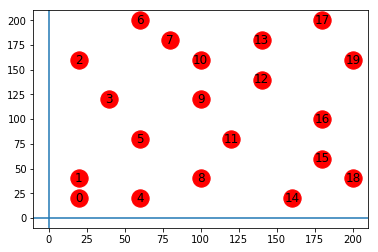

fitness: 0.0006618171323507985 (0/25) (1/100)
fitness: 0.0006618171323507985 (1/25) (2/100)
fitness: 0.000708603784744811 (0/25) (3/100)
fitness: 0.000708603784744811 (1/25) (4/100)
fitness: 0.0007139482856717178 (0/25) (5/100)
fitness: 0.0007698357848846632 (0/25) (6/100)
fitness: 0.0007983689043366806 (0/25) (7/100)
fitness: 0.0007983689043366806 (1/25) (8/100)
fitness: 0.0007983689043366806 (2/25) (9/100)
fitness: 0.0008510933885496356 (0/25) (10/100)
fitness: 0.0008698353080093925 (0/25) (11/100)
fitness: 0.00090531507426708 (0/25) (12/100)
fitness: 0.00090531507426708 (1/25) (13/100)
fitness: 0.00090531507426708 (2/25) (14/100)
fitness: 0.0009289465527486804 (0/25) (15/100)
fitness: 0.0009880933329723801 (0/25) (16/100)
fitness: 0.0009955414397033004 (0/25) (17/100)
fitness: 0.0010031098821181104 (0/25) (18/100)
fitness: 0.0010031098821181104 (1/25) (19/100)
fitness: 0.0010330212612005825 (0/25) (20/100)
fitness: 0.0010340714342239044 (0/25) (21/100)
fitness: 0.001051017288666738 

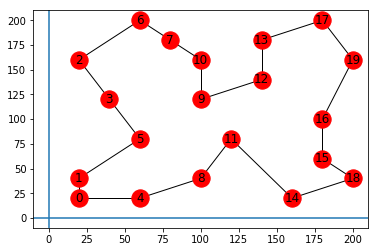

In [22]:
GA_coord_data.run()

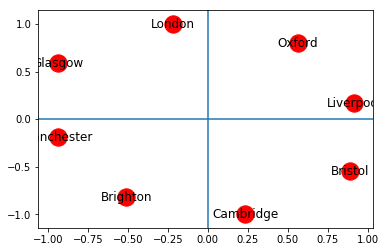

fitness: 0.0007017543859649122 (0/25) (1/100)
fitness: 0.0007380073800738007 (0/25) (2/100)
fitness: 0.0007380073800738007 (1/25) (3/100)
fitness: 0.0007380073800738007 (2/25) (4/100)
fitness: 0.0007380073800738007 (3/25) (5/100)
fitness: 0.0007380073800738007 (4/25) (6/100)
fitness: 0.0007380073800738007 (5/25) (7/100)
fitness: 0.0007380073800738007 (6/25) (8/100)
fitness: 0.0007380073800738007 (7/25) (9/100)
fitness: 0.0007380073800738007 (8/25) (10/100)
fitness: 0.0007380073800738007 (9/25) (11/100)
fitness: 0.0007380073800738007 (10/25) (12/100)
fitness: 0.0007380073800738007 (11/25) (13/100)
fitness: 0.0007380073800738007 (12/25) (14/100)
fitness: 0.0007380073800738007 (13/25) (15/100)
fitness: 0.0007380073800738007 (14/25) (16/100)
fitness: 0.0007380073800738007 (15/25) (17/100)
fitness: 0.0007380073800738007 (16/25) (18/100)
fitness: 0.0007380073800738007 (17/25) (19/100)
fitness: 0.0007380073800738007 (18/25) (20/100)
fitness: 0.0007380073800738007 (19/25) (21/100)
fitness: 0.0

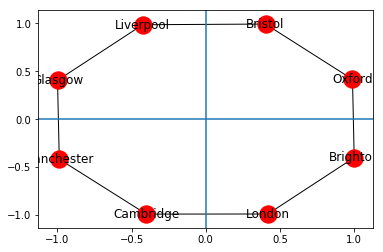

In [24]:
GA_map_data.run()